In [13]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../Utils')
import configs
# =========================
# 1. DATASET LOADER
# =========================
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=1024):
        self.root_dir = root_dir
        self.num_points = num_points
        self.classes = sorted(os.listdir(root_dir))
        self.files = []
        for label, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            for ext in ["*.pts", "*.txt", "*.xyz"]:
                for f in glob.glob(os.path.join(cls_dir, ext)):
                    self.files.append((f, label))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        points = np.loadtxt(file_path, dtype=np.float32)

        # Keep only x,y,z
        if points.shape[1] > 3:
            points = points[:, :3]

        # Sample/pad to fixed num_points
        if points.shape[0] >= self.num_points:
            choice = np.random.choice(points.shape[0], self.num_points, replace=False)
        else:
            choice = np.random.choice(points.shape[0], self.num_points, replace=True)
        points = points[choice, :]

        # Normalize
        points = points - np.mean(points, axis=0)
        dist = np.max(np.linalg.norm(points, axis=1))
        points = points / dist

        return torch.from_numpy(points).float(), label

In [14]:

# =========================
# 2. DGCNN MODEL
# =========================
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2,1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2,1)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx

class DGCNN(nn.Module):
    def __init__(self, k=20, emb_dims=1024, num_classes=7, dropout=0.5):
        super(DGCNN, self).__init__()
        self.k = k
        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, 1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(128, 64, 1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(256, 256, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, emb_dims, 1, bias=False), nn.BatchNorm1d(emb_dims), nn.LeakyReLU(0.2))

        self.linear1 = nn.Linear(emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(dropout)

        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(dropout)

        self.linear3 = nn.Linear(256, num_classes)

    def get_graph_feature(self, x, k=20):
        batch_size, num_dims, num_points = x.size()
        x = x.view(batch_size, -1, num_points)
        idx = knn(x, k=k)
        device = x.device

        idx_base = torch.arange(0, batch_size, device=device).view(-1,1,1)*num_points
        idx = idx + idx_base
        idx = idx.view(-1)

        x = x.transpose(2,1).contiguous()
        feature = x.view(batch_size*num_points, -1)[idx, :]
        feature = feature.view(batch_size, num_points, k, num_dims)
        x = x.view(batch_size, num_points, 1, num_dims).repeat(1,1,k,1)
        feature = torch.cat((feature - x, x), dim=3).permute(0,3,1,2).contiguous()
        return feature

    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0,2,1)  # B,N,D -> B,D,N

        x = self.get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1)[0]

        x = self.get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1)[0]

        x = self.get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1)[0]

        x = self.get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1)[0]

        x = torch.cat((x1,x2,x3,x4), dim=1)
        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x,1).view(batch_size,-1)
        x2 = F.adaptive_avg_pool1d(x,1).view(batch_size,-1)
        x = torch.cat((x1,x2), dim=1)

        x = F.leaky_relu(self.bn6(self.linear1(x)),0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)),0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x


In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# =========================
# 1. TRAIN ONE EPOCH
# =========================
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for points, labels in train_loader:
        points, labels = points.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.max(1)[1]
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# =========================
# 2. EVALUATION FUNCTION
# =========================
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for points, labels in data_loader:
            points, labels = points.to(device), labels.to(device)
            outputs = model(points)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.max(1)[1]
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    # Concatenate all predictions/labels into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return avg_loss, accuracy, all_preds, all_labels


# =========================
# 3. PLOT TRAINING CURVES
# =========================
def plot_training_curves(history):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


# =========================
# 4. TRAINING PIPELINE
# =========================
def train_model(train_loader, val_loader, test_loader, device, epochs=70, lr=0.001):
    num_classes = len(train_loader.dataset.dataset.classes)
    model = DGCNN(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()

    # Final Test Evaluation
    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    plot_training_curves(history)

    return model, all_preds, all_labels


Epoch [1/100], Loss: 1.5172, Train Acc: 0.4427, Val Acc: 0.1786
Epoch [2/100], Loss: 1.2380, Train Acc: 0.5011, Val Acc: 0.2143
Epoch [2/100], Loss: 1.2380, Train Acc: 0.5011, Val Acc: 0.2143
Epoch [3/100], Loss: 1.1298, Train Acc: 0.5371, Val Acc: 0.5625
Epoch [3/100], Loss: 1.1298, Train Acc: 0.5371, Val Acc: 0.5625
Epoch [4/100], Loss: 1.0501, Train Acc: 0.5910, Val Acc: 0.5536
Epoch [4/100], Loss: 1.0501, Train Acc: 0.5910, Val Acc: 0.5536
Epoch [5/100], Loss: 1.0639, Train Acc: 0.5708, Val Acc: 0.3393
Epoch [5/100], Loss: 1.0639, Train Acc: 0.5708, Val Acc: 0.3393
Epoch [6/100], Loss: 1.0593, Train Acc: 0.6022, Val Acc: 0.5893
Epoch [6/100], Loss: 1.0593, Train Acc: 0.6022, Val Acc: 0.5893
Epoch [7/100], Loss: 0.9416, Train Acc: 0.6270, Val Acc: 0.5714
Epoch [7/100], Loss: 0.9416, Train Acc: 0.6270, Val Acc: 0.5714
Epoch [8/100], Loss: 0.9064, Train Acc: 0.6337, Val Acc: 0.4375
Epoch [8/100], Loss: 0.9064, Train Acc: 0.6337, Val Acc: 0.4375
Epoch [9/100], Loss: 0.8551, Train Acc: 

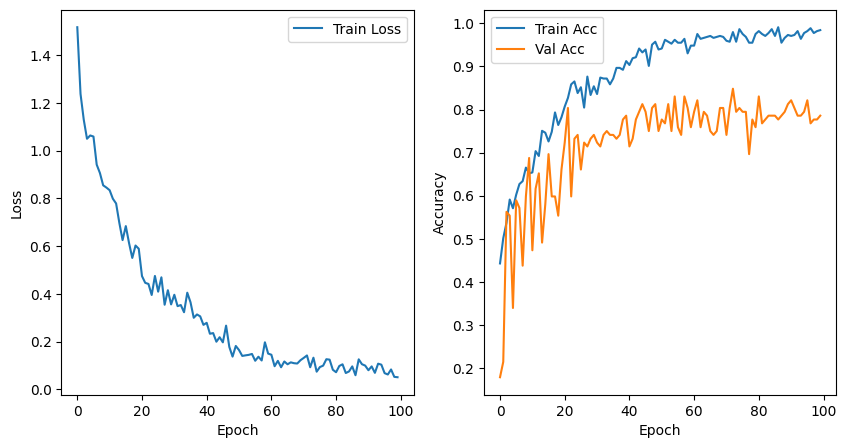

In [16]:
# 1. Load datasets
dataset = PointCloudDataset(configs.TRAIN_DIR)
test_dataset = PointCloudDataset(configs.TEST_DIR)

# 2. Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# 4. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# 5. Train model (returns model, predictions, labels)
model, all_preds, all_labels = train_model(train_loader, val_loader, test_loader, device, epochs=100, lr=0.001)



  Final Metrics on Test Set:
Accuracy: 0.8209
F1-score : 0.8083
Precision: 0.8387
Recall  : 0.8209

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.93      0.81      0.87        32
           2       0.82      0.86      0.84        36
           3       1.00      0.75      0.86         4
           4       0.80      0.80      0.80         5
           5       0.73      1.00      0.84        19
           6       0.79      0.84      0.81        31

    accuracy                           0.82       134
   macro avg       0.87      0.74      0.75       134
weighted avg       0.84      0.82      0.81       134



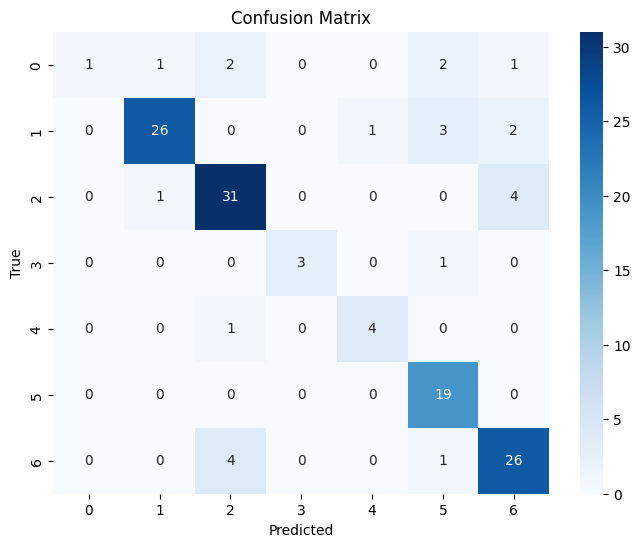

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"\n  Final Metrics on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall  : {recall:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))

# 7. Confusion Matrix Plot
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()